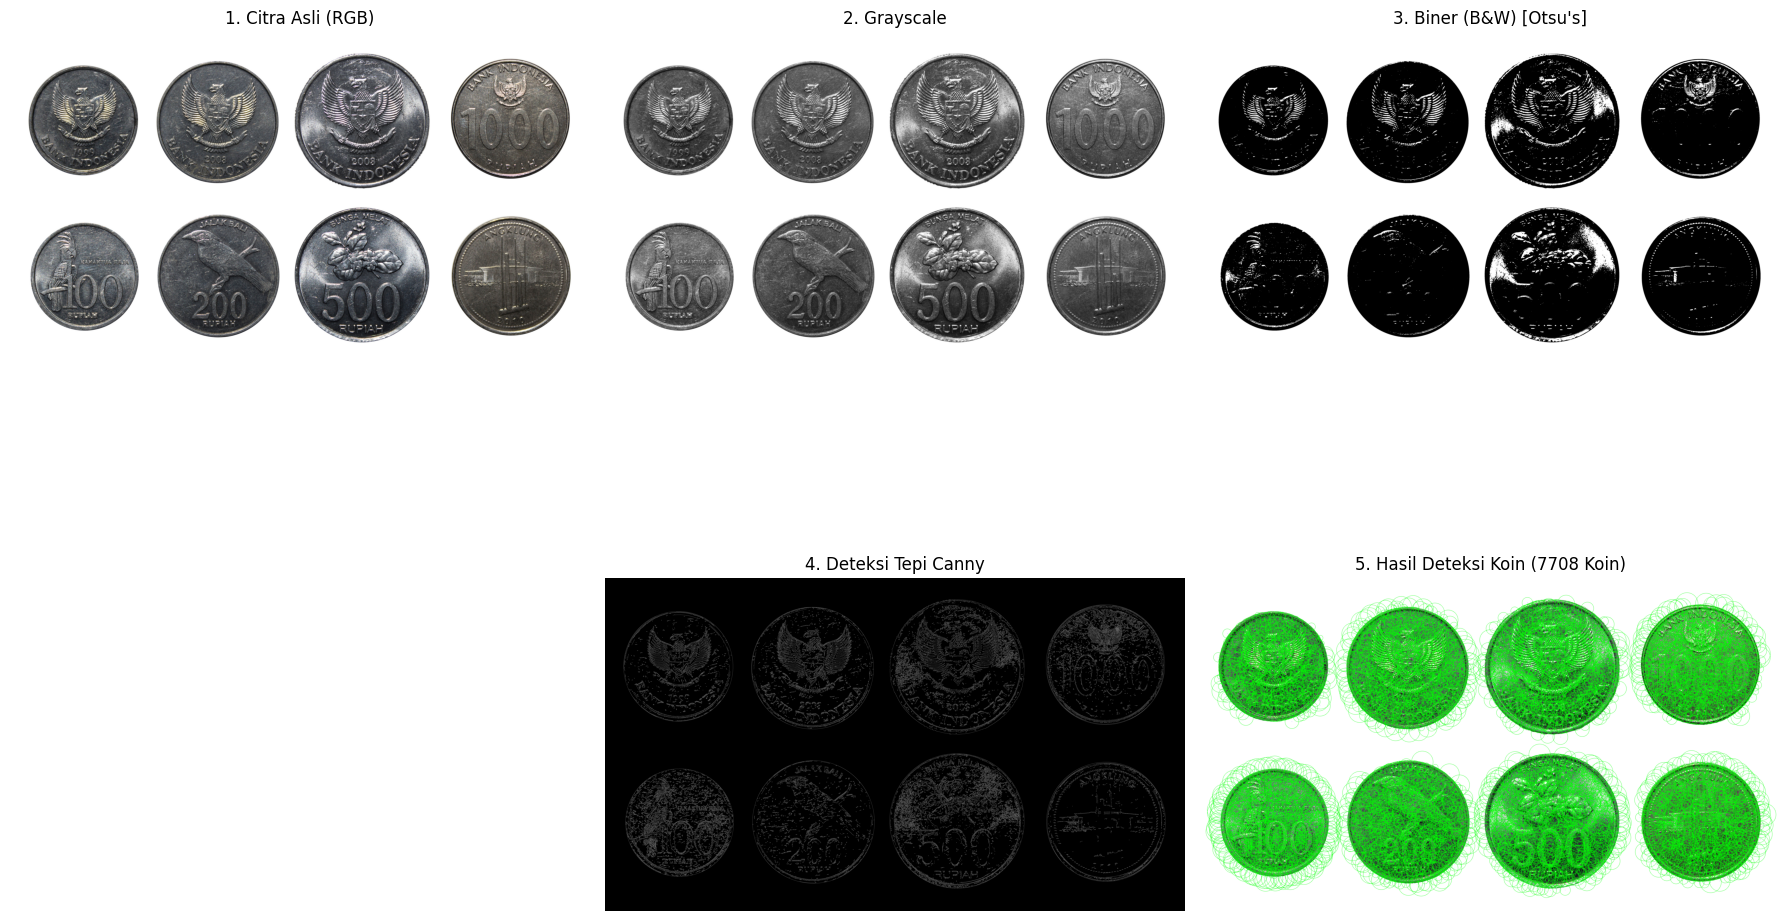


--- Hasil Akhir ---
Total Koin Terdeteksi: 7708 koin.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- PENGATURAN AWAL ---
# Ganti 'koin_rupiah.jpg' dengan nama file citra Anda. 
# Pastikan file citra berada di direktori yang sama atau berikan path lengkap.
image_path = 'tests/test1.png'

# Membaca citra
image = cv2.imread(image_path)

# Periksa apakah citra berhasil dimuat
if image is None:
    print(f"❌ ERROR: Tidak dapat memuat citra dari {image_path}. Pastikan path file benar.")
    exit()

# Konversi BGR ke RGB untuk ditampilkan dengan Matplotlib
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
output_image = image.copy()

# --- 1. PRE-PROCESSING: GRASCALE & BINARY ---

# 1.1. Konversi ke Grayscale (Wajib untuk Canny)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 1.2. Terapkan Gaussian Blur untuk mengurangi noise (membantu Canny)
# Kernel (5, 5) dan standar deviasi 0.
blurred = cv2.GaussianBlur(gray_image, (9, 9), 2)

# 1.3. Konversi ke Biner (B&W) menggunakan Otsu's Thresholding
# Meskipun tidak dipakai untuk Canny/Hough, ini bagus untuk visualisasi segmentasi.
_, binary_image = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


# --- 2. DETEKSI TEPI CANNY ---

# Terapkan Canny Edge Detection pada citra yang sudah di-blur
# Nilai threshold disesuaikan: 50 (min) dan 150 (max)
canny_edges = cv2.Canny(blurred, 50, 150)


# --- 3. DETEKSI BENTUK LINGKARAN (KOIN) MENGGUNAKAN HOUGH TRANSFORM ---

# Deteksi lingkaran menggunakan Hough Circle Transform
# dp=1 (resolusi sama), minDist=40 (jarak min antar pusat lingkaran)
# param1=50 (threshold Canny yang lebih tinggi), param2=30 (akumulator threshold)
# minRadius=20, maxRadius=150 (sesuaikan dengan ukuran koin)
circles = cv2.HoughCircles(
    blurred, 
    cv2.HOUGH_GRADIENT, 
    dp=1.2,          # Resolusi akumulator
    minDist=60,      # <--- SOLUSI 1: Jarak Minimum Ditingkatkan (60 piksel)
    param1=50,       # Canny threshold (tidak terlalu sensitif)
    param2=45,       # <--- SOLUSI 2: Akumulator Threshold Ditingkatkan (45)
    minRadius=30,    # <--- SOLUSI 3: Radius Minimum Diperketat
    maxRadius=120    # <--- SOLUSI 3: Radius Maksimum Diperketat
)

detected_count = 0

if circles is not None:
    # Konversi koordinat dan radius menjadi integer
    circles = np.uint16(np.around(circles))

    # Gambar lingkaran yang terdeteksi pada citra asli
    for i in circles[0, :]:
        center = (i[0], i[1]) # Koordinat pusat (x, y)
        radius = i[2] # Radius
        
        # Gambar lingkaran luar (warna hijau)
        cv2.circle(output_image, center, radius, (0, 255, 0), 2)
        
        # Gambar pusat lingkaran (warna merah)
        cv2.circle(output_image, center, 2, (255, 0, 0), -1)
        
        detected_count += 1
        
    output_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

else:
    output_rgb = rgb_image
    print("Tidak ada lingkaran (koin) yang terdeteksi.")


# --- 4. VISUALISASI HASIL ---

plt.figure(figsize=(18, 12))

# Subplot 1: Citra Asli
plt.subplot(2, 3, 1)
plt.title('1. Citra Asli (RGB)')
plt.imshow(rgb_image)
plt.axis('off')

# Subplot 2: Grayscale
plt.subplot(2, 3, 2)
plt.title('2. Grayscale')
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

# Subplot 3: Biner (B&W)
plt.subplot(2, 3, 3)
plt.title("3. Biner (B&W) [Otsu's]")
plt.imshow(binary_image, cmap='gray')
plt.axis('off')

# Subplot 4: Canny Edges
plt.subplot(2, 3, 5)
plt.title('4. Deteksi Tepi Canny')
plt.imshow(canny_edges, cmap='gray')
plt.axis('off')

# Subplot 5: Hasil Deteksi Koin
plt.subplot(2, 3, 6)
plt.title(f'5. Hasil Deteksi Koin ({detected_count} Koin)')
plt.imshow(output_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

# --- INFORMASI HASIL ---
print(f"\n--- Hasil Akhir ---")
print(f"Total Koin Terdeteksi: {detected_count} koin.")